# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs! 

In this document you will work through a similar process that we did in class with the NBA data files will be in the canvas assignment, merging them together.

Details: 

- Determine a way to use clustering to estimate based on performance if 
players are under or over paid, generally. 

- Then select players you believe would be best for your team and explain why. Do so in three categories: 
    * Examples that are not good choices (3 or 4) 
    * Several options that are good choices (3 or 4)
    * Several options that could work, assuming you can't get the players in the good category (3 or 4)

- You will decide the cutoffs for each category, so you should be able to explain why you chose them.

- Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations. 


Hints:

- Salary is the variable you are trying to understand 
- When interpreting you might want to use graphs that include variables that are the most correlated with Salary
- You'll need to scale the variables before performing the clustering
- Be specific about why you selected the players that you did, more detail is better
- Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used. 
- Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


In [67]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [68]:
# help(pd.read_csv)

In [69]:
# Read in data

nba1 = pd.read_csv('nba_2025.txt', sep = ',') # values appear to be separated by commas

nba2 = pd.read_csv('2025_salaries.csv', header = 1) # there is a header row, so need to make header = 1 or it will count that as a row of data

In [70]:
# Get rid of duplicate rows

nba1 = nba1.drop_duplicates(subset = 'Player', keep = 'first') # drops duplicated rows, and selects by the player column, keeping the first row (which will keep the grouped statistics row as 2TM will go before the team names)
nba2 = nba2.drop_duplicates(subset = 'Player', keep = 'first') # same thing since duplicate rows have the same numbers anyway, only difference is team which gets dropped, so no difference

In [71]:
# Merge datasets and drop missing values

nba = pd.merge(nba1, nba2, on = 'Player', how = 'inner') # inner merge to make sure missing data isn't obstructing the model and we have the salaries and stats for all players we're using/analyzing

In [72]:
#Drop variables that will not be needed or are duplicates

good_cols = ['Player', 'Pos', 'G', 'eFG%', 'FT%', 'PTS', 'AST', 'STL', 'BLK', 'TRB', '2025-26']

df = nba[good_cols]
df = df.dropna() # some rows still missing, but only a few, so we can just get rid of them
df

,Player,Pos,G,eFG%,FT%,PTS,AST,STL,BLK,TRB,2025-26
0,Shai Gilgeous-Alexander,PG,49.0,0.599,0.892,1558.0,314.0,64.0,38.0,218.0,"$38,333,050"
1,Tyrese Maxey,PG,52.0,0.547,0.889,1503.0,351.0,102.0,40.0,214.0,"$37,958,760"
2,Donovan Mitchell,SG,51.0,0.574,0.853,1478.0,302.0,79.0,15.0,229.0,"$46,394,100"
3,Jaylen Brown,SF,49.0,0.529,0.775,1435.0,229.0,49.0,20.0,336.0,"$53,142,264"
4,Jalen Brunson,PG,50.0,0.541,0.847,1351.0,305.0,36.0,5.0,166.0,"$34,944,001"
...,...,...,...,...,...,...,...,...,...,...,...
408,Brandon Clarke,PF,2.0,0.333,0.500,8.0,1.0,2.0,0.0,6.0,"$12,500,000"
409,Dillon Jones,SF,4.0,0.300,1.000,7.0,3.0,2.0,0.0,5.0,"$2,753,280"
410,Isaac Jones,PF,4.0,0.500,0.500,5.0,1.0,0.0,0.0,2.0,"$1,955,377"
411,Garrett Temple,SG,13.0,0.214,0.500,4.0,4.0,3.0,1.0,4.0,"$2,296,274"


In [73]:
# Slightly alter some columns for use

df['PPG'] = df['PTS'] / df['G'] # make these standardized to the amount of games to make comparison fair since obviously more playtime leads to more points and assists (usually)
df['APG'] = df['AST'] / df['G'] 
df['SPG'] = df['STL'] / df['G'] # do the same for some more defense-based stats too
df['BPG'] = df['BLK'] / df['G']
df['RPG'] = df['TRB'] / df['G'] # total rebounds per game (average)

df = df.drop(columns = ['PTS', 'AST', 'STL', 'BLK', 'TRB', 'G']) # don't need these anymore, so get rid of them

df = df.rename(columns = {'2025-26': 'Salary'}) # purely for convenience because typing out 2025-26 is more annoying than just salary
df['Salary'] = df['Salary'].replace('[\$,]', '', regex = True).astype(float) # adjusts salary to be a proper float without $ and commas, courtesy of https://stackoverflow.com/questions/32464280/how-to-convert-currency-column-with-and-to-numbers

df

<>:12: SyntaxWarning: invalid escape sequence '\$'
<>:12: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_4041/2500152984.py:12: SyntaxWarning: invalid escape sequence '\$'
  df['Salary'] = df['Salary'].replace('[\$,]', '', regex = True).astype(float) # adjusts salary to be a proper float without $ and commas, courtesy of https://stackoverflow.com/questions/32464280/how-to-convert-currency-column-with-and-to-numbers


,Player,Pos,eFG%,FT%,Salary,PPG,APG,SPG,BPG,RPG
0,Shai Gilgeous-Alexander,PG,0.599,0.892,38333050.0,31.795918,6.408163,1.306122,0.775510,4.448980
1,Tyrese Maxey,PG,0.547,0.889,37958760.0,28.903846,6.750000,1.961538,0.769231,4.115385
2,Donovan Mitchell,SG,0.574,0.853,46394100.0,28.980392,5.921569,1.549020,0.294118,4.490196
3,Jaylen Brown,SF,0.529,0.775,53142264.0,29.285714,4.673469,1.000000,0.408163,6.857143
4,Jalen Brunson,PG,0.541,0.847,34944001.0,27.020000,6.100000,0.720000,0.100000,3.320000
...,...,...,...,...,...,...,...,...,...,...
408,Brandon Clarke,PF,0.333,0.500,12500000.0,4.000000,0.500000,1.000000,0.000000,3.000000
409,Dillon Jones,SF,0.300,1.000,2753280.0,1.750000,0.750000,0.500000,0.000000,1.250000
410,Isaac Jones,PF,0.500,0.500,1955377.0,1.250000,0.250000,0.000000,0.000000,0.500000
411,Garrett Temple,SG,0.214,0.500,2296274.0,0.307692,0.307692,0.230769,0.076923,0.307692


In [74]:
# Scaling

num_cols = ['eFG%', 'FT%', 'PPG', 'APG', 'BPG', 'SPG', 'RPG']

scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])

In [75]:
# help(KMeans)

In [76]:
#Run the clustering algo with your best guess for K

kmeans4 = KMeans(n_clusters = 4, random_state = 42, verbose = 1)
kmeans4.fit(X)

Initialization complete
Iteration 0, inertia 2074.6019714400663.
Iteration 1, inertia 1546.6182999567015.
Iteration 2, inertia 1516.2477121928925.
Iteration 3, inertia 1507.6547898371985.
Iteration 4, inertia 1504.4415503220507.
Iteration 5, inertia 1502.870970630953.
Iteration 6, inertia 1501.5880258317804.
Iteration 7, inertia 1499.9609929189296.
Iteration 8, inertia 1499.3837010156956.
Iteration 9, inertia 1498.3557201247681.
Iteration 10, inertia 1498.3067733898386.
Converged at iteration 10: strict convergence.


,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",4
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",1
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [77]:
#View the results
print(kmeans4.labels_)

df['cluster'] = kmeans4.labels_

df

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 0 2 2 2 2 3 2 3 2 2 3 2
 2 2 2 3 2 2 2 2 2 2 3 2 2 3 2 3 0 0 0 3 2 3 2 3 2 3 2 0 0 2 3 0 2 0 2 0 0
 3 0 2 0 2 2 2 0 3 0 2 3 0 0 0 0 0 2 0 0 0 3 2 0 3 3 0 3 0 2 0 0 3 0 2 3 3
 0 3 0 2 2 3 3 2 3 0 0 2 0 0 0 0 0 0 3 2 0 0 0 0 2 0 0 0 0 3 2 0 3 0 0 2 3
 3 0 0 2 0 2 1 2 0 0 0 0 2 0 0 0 3 0 0 0 0 0 2 0 0 1 2 0 0 3 2 0 0 0 3 0 0
 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 1 0 0 3 1 0 0 0 0 1 3 0 0 0 0 0 3 0 0 0 3 0
 1 0 1 3 0 2 0 0 0 0 0 1 1 0 0 3 3 0 0 1 1 3 0 0 1 0 0 0 0 0 0 1 0 3 3 1 1
 0 2 0 1 0 1 0 0 0 0 3 1 0 1 1 0 1 1 1 1 1 1 1 1 1 3 1 0 2 0 1 0 3 1 3 0 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 3 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 0
 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 0 2 1 3 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1]


,Player,Pos,eFG%,FT%,Salary,PPG,APG,SPG,BPG,RPG,cluster
0,Shai Gilgeous-Alexander,PG,0.599,0.892,38333050.0,31.795918,6.408163,1.306122,0.775510,4.448980,2
1,Tyrese Maxey,PG,0.547,0.889,37958760.0,28.903846,6.750000,1.961538,0.769231,4.115385,2
2,Donovan Mitchell,SG,0.574,0.853,46394100.0,28.980392,5.921569,1.549020,0.294118,4.490196,2
3,Jaylen Brown,SF,0.529,0.775,53142264.0,29.285714,4.673469,1.000000,0.408163,6.857143,2
4,Jalen Brunson,PG,0.541,0.847,34944001.0,27.020000,6.100000,0.720000,0.100000,3.320000,2
...,...,...,...,...,...,...,...,...,...,...,...
408,Brandon Clarke,PF,0.333,0.500,12500000.0,4.000000,0.500000,1.000000,0.000000,3.000000,1
409,Dillon Jones,SF,0.300,1.000,2753280.0,1.750000,0.750000,0.500000,0.000000,1.250000,1
410,Isaac Jones,PF,0.500,0.500,1955377.0,1.250000,0.250000,0.000000,0.000000,0.500000,1
411,Garrett Temple,SG,0.214,0.500,2296274.0,0.307692,0.307692,0.230769,0.076923,0.307692,1


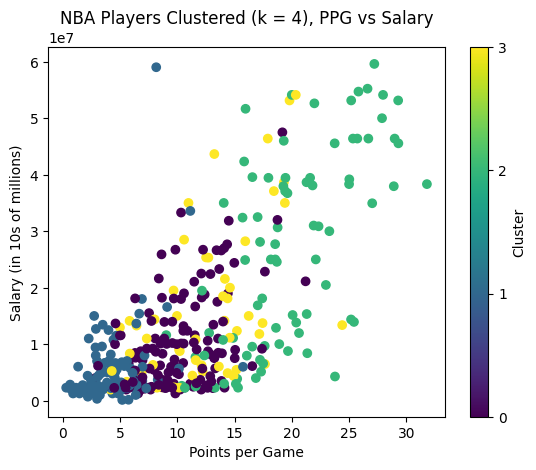

In [78]:
#Create a visualization of the results with 2 or 3 variables that you think will best
#differentiate the clusters

plt.scatter(df['PPG'], df['Salary'], c = df['cluster'])
plt.colorbar(label = 'Cluster', ticks = [0, 1, 2, 3])
plt.xlabel('Points per Game')
plt.ylabel('Salary (in 10s of millions)')
plt.title('NBA Players Clustered (k = 4), PPG vs Salary')
plt.show()

In [79]:
#Evaluate the quality of the clustering using total variance explained and silhouette scores

total_sum_squares = np.sum(np.sum((X - np.mean(X)) ** 2)) # calculates distance between each point and squares it
between_clusters_ss = total_sum_squares - kmeans4.inertia_ # subtracts the inertia (distance of each point from cluster center squared) from total distances squared
var_explained = between_clusters_ss / total_sum_squares # formula used in cluster_utils.py

sil_score = silhouette_score(X, kmeans4.labels_)

print(f'Variance explained: {var_explained}') # how well separated clusters are (0-1), higher is better
print(f'Silhouette score: {sil_score}') # fit of points within cluster versus other nearby clusters (-1 - 1), higher better fit for cluster, 0 on border of clusters

Variance explained: 0.4753827824265271
Silhouette score: 0.19497995387733738


In [80]:
#Determine the ideal number of clusters using the elbow method and the silhouette coefficient

inertias = []
sil_scores = []
k_vals = list(range(2, 11))
for k in k_vals:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, kmeans.labels_))

ideal = k_vals[sil_scores.index(max(sil_scores))]
print(f'Ideal k: {ideal}')

Ideal k: 3


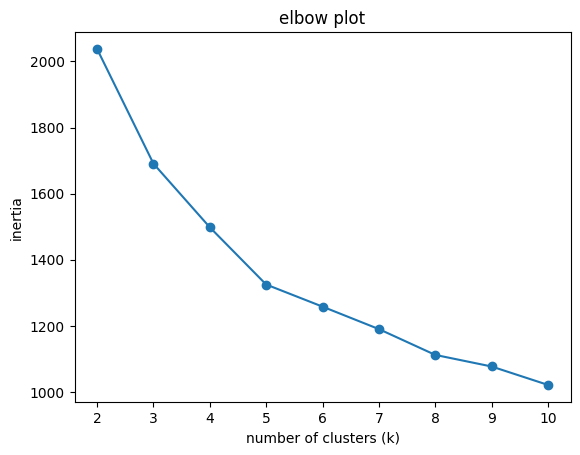

In [81]:
#Visualize the results of the elbow method

plt.plot(k_vals, inertias, marker = 'o')
plt.xlabel('number of clusters (k)')
plt.ylabel('inertia')
plt.title('elbow plot')
plt.show()

This elbow plot is a bit strange because it doesn't have a super defined elbow point, and the k the above code provided was 3.

Initialization complete
Iteration 0, inertia 2454.470158664061.
Iteration 1, inertia 1801.7783826466.
Iteration 2, inertia 1760.4421912809635.
Iteration 3, inertia 1747.4928293724493.
Iteration 4, inertia 1731.2297401996211.
Iteration 5, inertia 1710.2409178984929.
Iteration 6, inertia 1700.8206474044487.
Iteration 7, inertia 1695.8148737938238.
Iteration 8, inertia 1692.6163876167275.
Iteration 9, inertia 1692.1339862554364.
Iteration 10, inertia 1691.2497485169613.
Iteration 11, inertia 1691.0106129015112.
Iteration 12, inertia 1690.921247537268.
Converged at iteration 12: strict convergence.
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 0 2 2 0 2
 2 2 2 0 2 2 2 2 2 2 0 2 0 0 2 0 2 0 2 0 2 0 2 0 2 0 2 1 1 2 0 2 2 2 2 2 2
 0 1 2 2 2 2 2 0 0 0 2 0 1 2 1 1 2 2 2 1 2 0 2 1 0 0 1 0 1 2 1 0 0 2 2 0 0
 0 0 0 2 2 0 0 2 0 2 2 2 1 1 2 1 1 0 0 2 2 0 1 1 2 1 2 1 2 0 2 2 0 1 1 2 0
 0 1 0 2 2 2 1 2 1 1 1 2 2 2 0 1 0 1 0 2 1 2 2 1 2 1 2 1 1 0 2 1 1 1 0 2 1
 1 1 1 2 1 1 0 2 2 0 2 

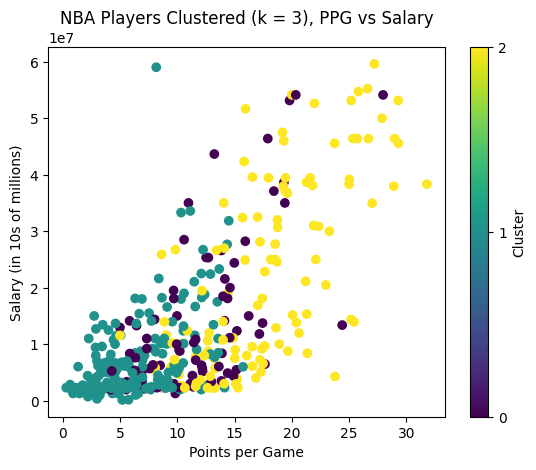

In [82]:
#Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

kmeans3 = KMeans(n_clusters = 3, random_state = 42, verbose = 1)
kmeans3.fit(X)

print(kmeans3.labels_)

df['cluster'] = kmeans3.labels_

print(df)

plt.scatter(df['PPG'], df['Salary'], c = df['cluster'])
plt.colorbar(label = 'Cluster', ticks = [0, 1, 2])
plt.xlabel('Points per Game')
plt.ylabel('Salary (in 10s of millions)')
plt.title('NBA Players Clustered (k = 3), PPG vs Salary')
plt.show()

In [83]:
#Once again evaluate the quality of the clustering using total variance explained and silhouette scores

total_sum_squares = np.sum(np.sum((X - np.mean(X)) ** 2)) # calculates distance between each point and squares it
between_clusters_ss = total_sum_squares - kmeans3.inertia_ # subtracts the inertia (distance of each point from cluster center squared) from total distances squared
var_explained = between_clusters_ss / total_sum_squares # formula used in cluster_utils.py

sil_score = silhouette_score(X, kmeans3.labels_)

print(f'Variance explained: {var_explained}') # how well separated clusters are (0-1), higher is better
print(f'Silhouette score: {sil_score}') # fit of points within cluster versus other nearby clusters (-1 - 1), higher better fit for cluster, 0 on border of clusters

Variance explained: 0.4079407396578193
Silhouette score: 0.27139863836940925


This is also interesting because the k = 3 model decreased variance explained, but increased silhouette score, so it becomes a tradeoff between the two. The middle cluster could be useful for identifying players who may have less salary, but higher stats like PPG.

In [84]:
#Use the model to select players for Mr. Rooney to consider

# Not Good Choices
df[(df['PPG'] <= 5) & (df['Salary'] >= 10000000)] # filter cutoffs of PPG and salary (players who don't score very often, but also are getting paid quite well anyway)

# Lonzo Ball
# Gabe Vincent
# Dorian Finney-Smith

,Player,Pos,eFG%,FT%,Salary,PPG,APG,SPG,BPG,RPG,cluster
283,Mike Conley,PG,0.443,0.891,10774038.0,4.431818,2.863636,0.590909,0.250000,1.772727,1
284,Mitchell Robinson,C,0.697,0.408,12954546.0,5.000000,0.974359,0.794872,1.153846,8.871795,0
303,Lonzo Ball,PG,0.415,0.667,10000000.0,4.571429,3.885714,1.285714,0.257143,4.000000,1
315,Josh Green,SG,0.620,0.875,13666667.0,4.612903,1.000000,0.580645,0.096774,1.935484,1
317,Gabe Vincent,PG,0.478,0.909,11500000.0,4.666667,1.366667,0.566667,0.033333,0.933333,1
325,Jonathan Isaac,PF,0.473,0.640,15000000.0,2.750000,0.386364,0.386364,0.568182,2.500000,1
336,Kelly Olynyk,C,0.538,0.667,13445122.0,3.500000,1.200000,0.433333,0.033333,1.866667,1
360,Maxi Kleber,PF,0.491,0.700,11000000.0,2.275862,0.689655,0.379310,0.206897,1.931034,1
365,Dorian Finney-Smith,PF,0.396,1.000,12700000.0,2.900000,0.750000,0.350000,0.200000,2.350000,1
395,Matisse Thybulle,SG,0.800,1.000,11550000.0,5.000000,0.750000,2.500000,0.000000,1.000000,2


In [85]:
# Good Choices
df[(df['PPG'] >= 15) & (df['Salary'] <= 5000000)] # filter cutoffs for players who score a good amount of points per game, but don't get paid very well (under $5 million)

# Keyonte George
# Ryan Rollins
# Russell Westbrook


,Player,Pos,eFG%,FT%,Salary,PPG,APG,SPG,BPG,RPG,cluster
17,Keyonte George,PG,0.535,0.894,4278960.0,23.770833,6.520833,1.083333,0.291667,3.895833,2
46,Ryan Rollins,PG,0.549,0.757,4000000.0,16.862745,5.450980,1.470588,0.392157,4.607843,2
57,Russell Westbrook,SF,0.509,0.697,2296274.0,15.307692,6.576923,1.307692,0.153846,5.692308,2
63,Jaime Jaquez Jr.,SF,0.527,0.748,3861600.0,15.235294,4.725490,0.843137,0.294118,5.431373,2
91,Kyshawn George,SF,0.527,0.797,2966760.0,15.116279,4.813953,1.069767,0.883721,5.441860,2


In [86]:
# Decent Choices (for if we can't get the good choices)

df[(df['PPG'] >= 10) & (df['PPG'] < 15) & (df['Salary'] <= 7500000)]

# Walker Kessler
# Jaylon Tyson
# Cam Spencer

,Player,Pos,eFG%,FT%,Salary,PPG,APG,SPG,BPG,RPG,cluster
64,Tim Hardaway Jr.,SG,0.596,0.859,2296274.0,14.129630,1.314815,0.518519,0.148148,2.629630,1
73,Toumani Camara,PF,0.564,0.702,2221677.0,13.107143,2.571429,1.000000,0.446429,5.357143,2
74,Peyton Watson,SF,0.567,0.727,4356476.0,14.918367,1.959184,1.020408,1.183673,4.897959,0
78,Collin Gillespie,PG,0.576,0.846,2296274.0,13.296296,4.685185,1.388889,0.222222,4.166667,2
83,Jaylon Tyson,SG,0.615,0.750,3492480.0,13.860000,2.300000,0.860000,0.400000,5.400000,0
85,Derik Queen,C,0.506,0.777,5157960.0,12.218182,4.145455,1.036364,0.909091,7.218182,0
88,Brice Sensabaugh,SF,0.544,0.849,2693760.0,12.547170,1.528302,0.679245,0.094340,2.943396,1
90,Brandin Podziemski,SG,0.535,0.767,3687960.0,12.018182,3.527273,1.127273,0.181818,4.581818,2
94,Cedric Coward,SG,0.539,0.843,5715120.0,13.312500,2.916667,0.562500,0.395833,6.229167,2
97,Jaylen Wells,SG,0.502,0.765,1955377.0,12.096154,1.653846,0.788462,0.115385,3.423077,1


In [87]:
#Write up the results in a separate notebook with supporting visualizations and 
# an overview of how and why you made the choices you did. This should be at least 
# 500 words and should be written for a non-technical audience.

# See writeup.ipynb

In [88]:
# help(plt.annotate)

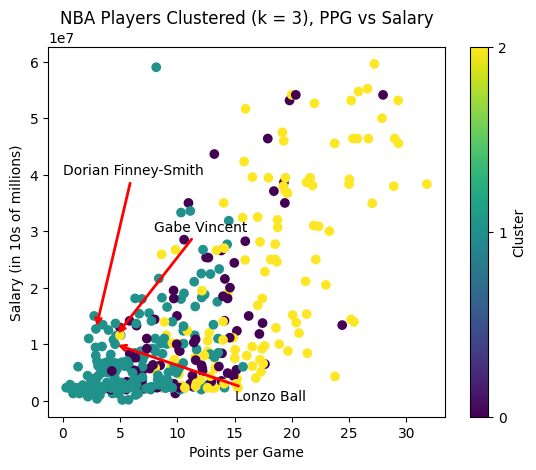

In [89]:
# Supporting visualizations for writeup to copy over to other notebook file

# Not Good Players

plt.scatter(df['PPG'], df['Salary'], c = df['cluster'])
plt.colorbar(label = 'Cluster', ticks = [0, 1, 2])

plt.annotate(text = 'Lonzo Ball', xy = (df.loc[df['Player'] == 'Lonzo Ball', 'PPG'].values[0], df.loc[df['Player'] == 'Lonzo Ball', 'Salary'].values[0]), 
             xytext = (15, 0),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
plt.annotate(text = 'Gabe Vincent', xy = (df.loc[df['Player'] == 'Gabe Vincent', 'PPG'].values[0], df.loc[df['Player'] == 'Gabe Vincent', 'Salary'].values[0]), 
             xytext = (8, 30000000),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
plt.annotate(text = 'Dorian Finney-Smith', xy = (df.loc[df['Player'] == 'Dorian Finney-Smith', 'PPG'].values[0], df.loc[df['Player'] == 'Dorian Finney-Smith', 'Salary'].values[0]), 
             xytext = (0, 40000000),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))


plt.xlabel('Points per Game')
plt.ylabel('Salary (in 10s of millions)')
plt.title('NBA Players Clustered (k = 3), PPG vs Salary')
plt.show()

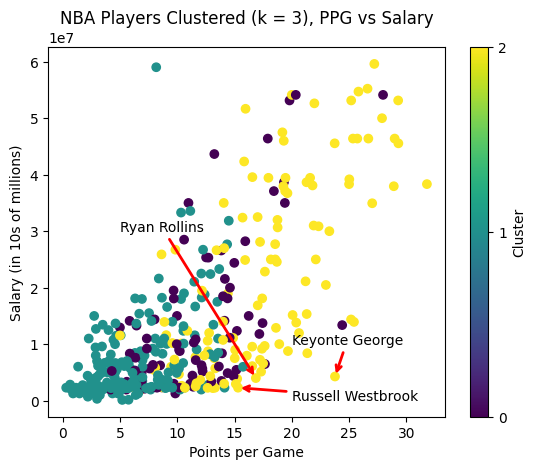

In [90]:
# Good Players

plt.scatter(df['PPG'], df['Salary'], c = df['cluster'])
plt.colorbar(label = 'Cluster', ticks = [0, 1, 2])

plt.annotate(text = 'Keyonte George', xy = (df.loc[df['Player'] == 'Keyonte George', 'PPG'].values[0], df.loc[df['Player'] == 'Keyonte George', 'Salary'].values[0]), 
             xytext = (20, 10000000),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
plt.annotate(text = 'Ryan Rollins', xy = (df.loc[df['Player'] == 'Ryan Rollins', 'PPG'].values[0], df.loc[df['Player'] == 'Ryan Rollins', 'Salary'].values[0]), 
             xytext = (5, 30000000),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
plt.annotate(text = 'Russell Westbrook', xy = (df.loc[df['Player'] == 'Russell Westbrook', 'PPG'].values[0], df.loc[df['Player'] == 'Russell Westbrook', 'Salary'].values[0]), 
             xytext = (20, 0),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))


plt.xlabel('Points per Game')
plt.ylabel('Salary (in 10s of millions)')
plt.title('NBA Players Clustered (k = 3), PPG vs Salary')
plt.show()

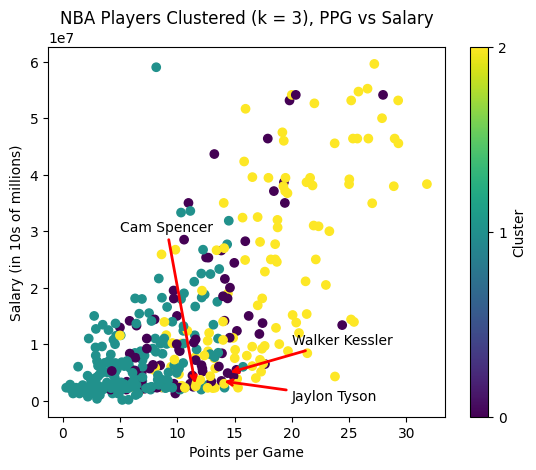

In [91]:
# Decent Players

plt.scatter(df['PPG'], df['Salary'], c = df['cluster'])
plt.colorbar(label = 'Cluster', ticks = [0, 1, 2])

plt.annotate(text = 'Walker Kessler', xy = (df.loc[df['Player'] == 'Walker Kessler', 'PPG'].values[0], df.loc[df['Player'] == 'Walker Kessler', 'Salary'].values[0]), 
             xytext = (20, 10000000),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
plt.annotate(text = 'Jaylon Tyson', xy = (df.loc[df['Player'] == 'Jaylon Tyson', 'PPG'].values[0], df.loc[df['Player'] == 'Jaylon Tyson', 'Salary'].values[0]), 
             xytext = (20, 0),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
plt.annotate(text = 'Cam Spencer', xy = (df.loc[df['Player'] == 'Cam Spencer', 'PPG'].values[0], df.loc[df['Player'] == 'Cam Spencer', 'Salary'].values[0]), 
             xytext = (5, 30000000),
             arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))

plt.xlabel('Points per Game')
plt.ylabel('Salary (in 10s of millions)')
plt.title('NBA Players Clustered (k = 3), PPG vs Salary')
plt.show()